### Zadanie 1

In [68]:
#importowanie pakietów potrzebnych do wykonania zadania
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
import datetime
import mplfinance as mplf
import plotly.graph_objects as go
import scipy.stats as stats
import pylab
import statsmodels.api as sm
import arch
warnings.filterwarnings('ignore')

In [69]:
#określenie początkowej i końcowej daty
startDate = datetime.datetime(2023, 1, 1)
endDate = datetime.datetime(2023, 3, 1)
#pobranie danych z yahoo finance (cena otwarcia, zamknięcia, najwyższa, najniższa) dla firmy META
data = yf.Ticker("META").history(start=startDate, end=endDate, interval="1d")[['Open', 'Close', 'High', 'Low']]
#utworzenie wykresu świecowego
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
fig.update_layout(title="Wykres świeciowy dla firmy META",
                  yaxis_title="Cena",
                  xaxis_title="Data",
                  xaxis_rangeslider_visible=False)
fig.update_xaxes(dtick="D1", tickformat="%d %b %Y", tickangle=90)

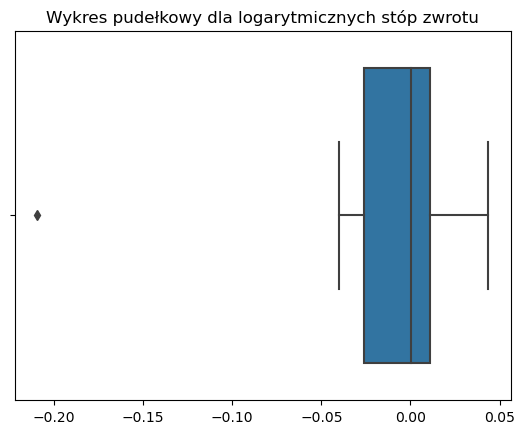

In [70]:
#obliczanie logarytmicznych stóp zwrotu
data['log_returns'] = np.log(data['Close']) - np.log(data['Close']).shift(-1)
#obliczenie statystyk opisowych dla logarytmicznych stóp zwrotu
data['log_returns'].describe(percentiles=[.01, .05, .95, .99])[1:]
#tworzenie wykresu pudełkowego dla logarytmicznych stóp zwrotu
sns.boxplot(data['log_returns'], orient='h')
plt.title("Wykres pudełkowy dla logarytmicznych stóp zwrotu")
plt.yticks([0], [''])
plt.show()

Jak widać wyliczone stopy zwrotu skupiają się wokół 0, wartości odstające pojawiają się natomiast dla wartości ujemnych.

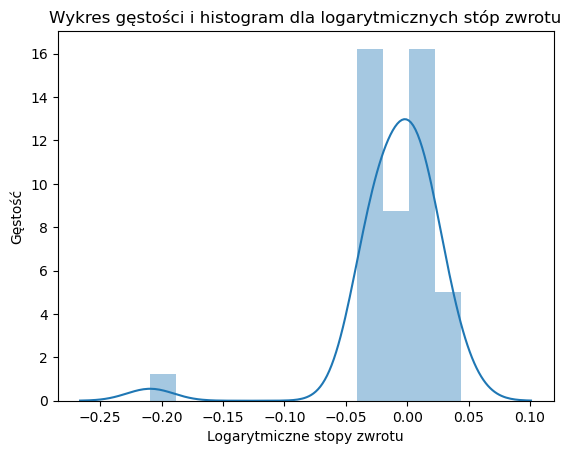

In [71]:
#stworzenie histogramu i wykresu gęstości dla logarytmicznych stóp zwrotu
sns.distplot(data['log_returns'], hist=True, kde=True).set(xlabel='Logarytmiczne stopy zwrotu',ylabel='Gęstość')
plt.title("Wykres gęstości i histogram dla logarytmicznych stóp zwrotu")
plt.show()

Na histogramie połączonym z funkcją gęstości widać obserwację wyczytaną z wykresu pudełkowego. Lewy ogon ciągnie się zdecydowanie dalej i jest grubszy, po prawej stronie taka sytuacja nie występuje.

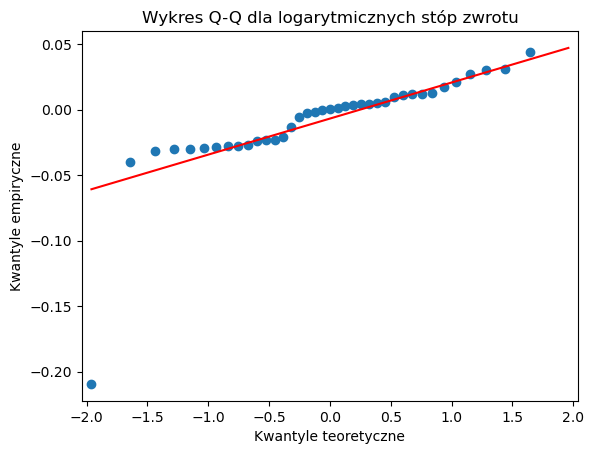

In [72]:
#stworzenie q-q plot dla logarytmicznych stóp zwrotu
sm.qqplot(data['log_returns'], line='q',xlabel='Kwantyle teoretyczne',ylabel='Kwantyle empiryczne')
plt.title("Wykres Q-Q dla logarytmicznych stóp zwrotu")
pylab.show()

In [73]:
#sprawdzenie z pomocą testu Shapiro-Wilka czy logarytmiczne stopy zwrotu mają rozkład normalny
#H0: dane mają rozkład normalny
#H1: dane nie mają rozkładu normalnego
shapiro_wilk = stats.shapiro(data['log_returns'].dropna())
print("P-value: ", shapiro_wilk[1])
if shapiro_wilk[1] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o normalności rozkładu logarytmicznych stóp zwrotu")


P-value:  3.5362972994334996e-08
P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu


In [74]:
#sprawdzenie z pomocą testu Jarque-Bera czy logarytmiczne stopy zwrotu mają rozkład normalny
#H0: dane mają rozkład normalny
#H1: dane nie mają rozkładu normalnego
jarque_bera = stats.jarque_bera(data['log_returns'].dropna())
print("P-value: ", jarque_bera[1])
if jarque_bera[1] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o normalności rozkładu logarytmicznych stóp zwrotu")

P-value:  1.1454720147749795e-102
P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu


Oba przeprowadzone testy formalne dają nam podstawy do odrzucenia ich hipotez zerowych, mówiących o normalności rozkładu. Rozkład stóp zwrotu nie jest zatem rozkładem normalnym.

In [75]:
#sprawdzenie z pomocą testu Ljung-Boxa czy występuje autokorelacja dla stóp zwrotu
#H0: nie występuje autokorelacja
#H1: występuje autokorelacja
ljung_box = sm.stats.acorr_ljungbox(data['log_returns'].dropna(), lags=[10], return_df=True)
if ljung_box["lb_pvalue"].values[0] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o braku autokorelacji dla stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o braku autokorelacji dla stóp zwrotu")

P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o braku autokorelacji dla stóp zwrotu


In [76]:
#sprawdzenie z pomocą testu Durbin-Watsona czy zmienne są niezależne
#H0: zmienne są niezależne
#H1: zmienne nie są niezależne
durbin_watson = sm.stats.durbin_watson(data['log_returns'].dropna())
if durbin_watson < 1.5 or durbin_watson > 2.5:
    print("Statystyka Durbin-Watsona wynosi: ", durbin_watson)
    print("Statystyka Durbin-Watsona nie należy do przedziału [1.5, 2.5] więc odrzucamy hipotezę zerową o niezależności zmiennych")
else:
    print("Statystyka Durbin-Watsona wynosi: ", durbin_watson)
    print("Statystyka Durbin-Watsona należy do przedziału [1.5, 2.5] więc nie odrzucamy hipotezy zerowej o niezależności zmiennych")

Statystyka Durbin-Watsona wynosi:  1.8532692258574819
Statystyka Durbin-Watsona należy do przedziału [1.5, 2.5] więc nie odrzucamy hipotezy zerowej o niezależności zmiennych


Według dwóch kolejnych testów dane te nie są niezależne, występuje równiez autokorelacja.

In [77]:
#obliczenie średniej i odchylenia standardowego stóp zwrotu
mean = data['log_returns'].mean()
std = data['log_returns'].std()
#stworzenie tabeli do porównania 
comparison = pd.DataFrame(columns=["returns"])
comparison["returns"] = [0]*11
comparison["normal_distribution"] = [0]*11
comparison["chebyshev_inequality"] = [0]*11
#uzupełnienie tabeli 
for i in range(1,11):
    #odsetkami stóp zwrotu w przedziale  (średnia - i*odchylenie standardowe; średnia + i*odchylenie standardowe)
    comparison["returns"][i] = len(data[(data['log_returns'] < mean+std*i) & (data['log_returns'] > mean-std*i)])/len(data)
    #analogicznymi odsetkami dla rozkładu normalnego
    comparison["normal_distribution"][i] = stats.norm.cdf(mean+std*i, mean, std) - stats.norm.cdf(mean-std*i, mean, std)
    #analogicznymi odsetkami dla nierówności Czebyszewa
    comparison["chebyshev_inequality"][i] = 1 - 1/(i**2)
comparison.drop(comparison.index[0], inplace=True)
print(comparison)

     returns  normal_distribution  chebyshev_inequality
1   0.897436             0.682689              0.000000
2   0.948718             0.954500              0.750000
3   0.948718             0.997300              0.888889
4   0.948718             0.999937              0.937500
5   0.948718             0.999999              0.960000
6   0.974359             1.000000              0.972222
7   0.974359             1.000000              0.979592
8   0.974359             1.000000              0.984375
9   0.974359             1.000000              0.987654
10  0.974359             1.000000              0.990000


W porównaniu z rozkładem normalnym rozkład stóp zwrotu najpierw zawiera większy odsetek obserwacji zawartych między średnią +- i odchyleniami standardowymi, a następnie mniejszy odsetek obserwacji zawartych w tym przedziale. Podobnie ma się to w przypadku nierówności Czebyszewa.

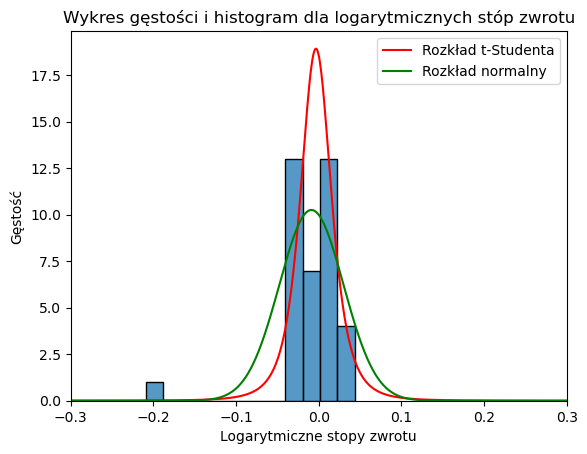

In [78]:
#estymuje najlepszy rozkład t-Studenta dla wektora stóp zwrotu i porównanie jego dopasowania z rozkładem normalnym o średniej i wariancji pochodzącymi z wektora stóp zwrotu

#estymacja parametrów rozkładu t-Studenta
params = stats.t.fit(data['log_returns'].dropna())
#estymacja parametrów rozkładu normalnego
params_normal = stats.norm.fit(data['log_returns'].dropna())

#stworzenie wektora wartości dla rozkładu t-Studenta i normalnego
x = np.linspace(data['log_returns'].min()-0.3, data['log_returns'].max()+0.3, 1000)
pdf_fitted_t = stats.t.pdf(x, *params)
pdf_fitted_normal = stats.norm.pdf(x, *params_normal)

#stworzenie histogramu i wykresu gęstości dla stóp zwrotu
sns.histplot(data['log_returns']).set(xlabel='Logarytmiczne stopy zwrotu',ylabel='Gęstość',xlim=(-0.3,0.3))
#dodanie do wykresu gęstości rozkładu t-Studenta i normalnego
plt.plot(x, pdf_fitted_t, color='r')
plt.plot(x, pdf_fitted_normal, color='g')
plt.legend(['Rozkład t-Studenta', 'Rozkład normalny'])
plt.title("Wykres gęstości i histogram dla logarytmicznych stóp zwrotu")
plt.show()

Jak widać na powyższym wykresie rozkłady te różnią się od siebie w zauważalnym stopniu.

Iteration:      2,   Func. Count:     17,   Neg. LLF: 10607628735.122944
Iteration:      4,   Func. Count:     37,   Neg. LLF: 32205899759.05746
Optimization terminated successfully    (Exit mode 0)
            Current function value: -585.4649224309653
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 5


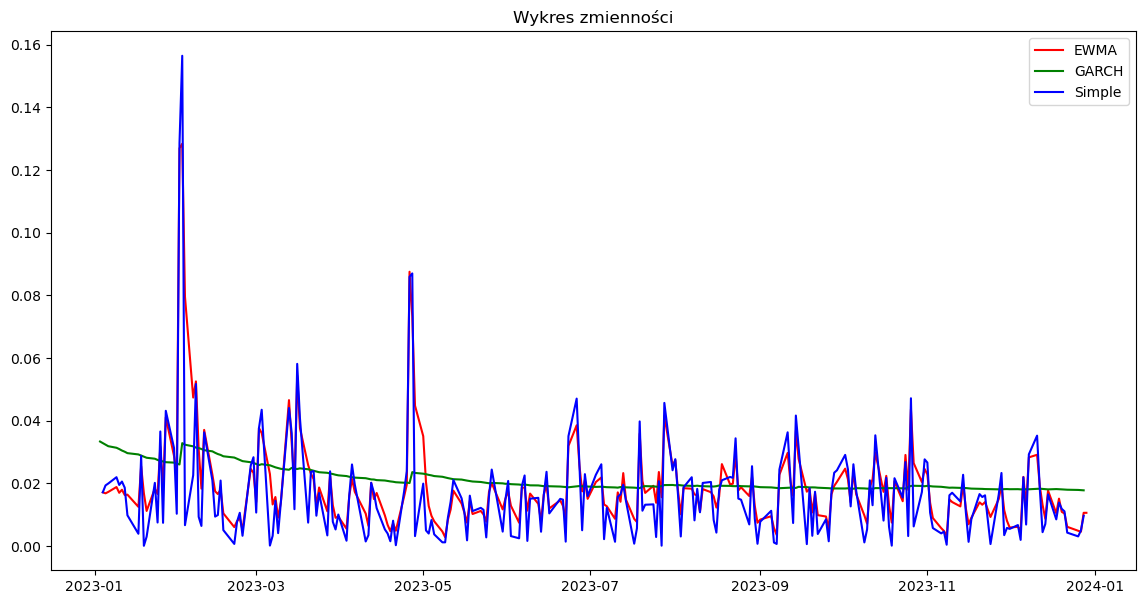

In [97]:
#określenie początkowej i końcowej daty
startDate = datetime.datetime(2023, 1, 1)
endDate = datetime.datetime(2023, 12, 31)
#pobranie danych z yahoo finance (cena otwarcia, zamknięcia, najwyższa, najniższa)
data = yf.Ticker("META").history(start=startDate, end=endDate, interval="1d")[['Open', 'Close', 'High', 'Low']]
#obliczanie logarytmicznych stóp zwrotu
data['log_returns'] = np.log(data['Close']) - np.log(data['Close']).shift(-1)

#estymowanie zmienności
#estymacja zmienności z wykorzystaniem metody EWMA
data['volatility_EWMA'] = data['log_returns'].ewm(span=2).std()
#estymacja zmienności z użyciem średniej ruchomej
data['volatility_SMA'] = data['log_returns'].rolling(window=2).std()
#estymacja zmienności z użyciem modelu garch(1,1)
garch = arch.arch_model(data['log_returns'].dropna(), p=1, q=1)
res = garch.fit(update_freq=2)
data['volatility_GARCH'] = res.conditional_volatility

#przedstawienie wyliczonych zmienności na wykresie
plt.figure(figsize=(14, 7))
plt.plot(data['volatility_EWMA'], color='r')
plt.plot(data['volatility_GARCH'], color='g')
plt.plot(data['volatility_SMA'], color='b')
plt.legend(['EWMA','GARCH','Simple'])
plt.title("Wykres zmienności")
plt.show()

Model GARCH(1,1) na tym zbiorze danych sprawdza się niezbyt dobrze, natomiast model EWMA i średnia ruchoma dają podobne do siebie wyniki.